In [1]:
import pandas as pd 
import numpy as np 
scallop = pd.read_csv("scallop.csv", usecols = ["latitude", "longitude","tot.catch"])
scallop.head()

,latitude,longitude,tot.catch
0,40.55000,-71.55000,0
1,40.46667,-71.51667,0
2,40.51667,-71.71667,0
3,40.38333,-71.85000,1
4,40.31667,-71.78333,0


Divided data by longitude

In [2]:
data = scallop.copy()
data["tot.catch"] = np.log(scallop["tot.catch"] + 1)
# choose longitude more than -72 as testing data
train = data[data["longitude"]< -72]
test = data[data["longitude"]>= -72]

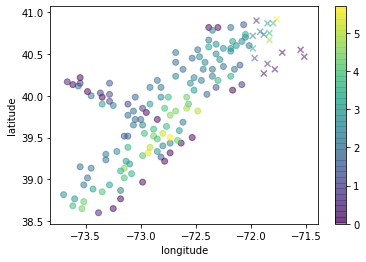

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(train["longitude"], train["latitude"], alpha=0.5,
            c=train["tot.catch"], cmap='viridis')
plt.scatter(test["longitude"], test["latitude"], alpha=0.5,
            c=test["tot.catch"], cmap='viridis',  marker='x')
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude");

In [4]:
X_2D_train = np.c_[train["longitude"],  train["latitude"]]
Y_2D_train = np.array(train["tot.catch"])

X_2D_test = np.c_[test["longitude"],  test["latitude"]]
Y_2D_test = np.array(test["tot.catch"])

rx = np.arange(min(data["longitude"]), max(data["longitude"]), 0.06)
ry = np.arange(min(data["latitude"]), max(data["latitude"]), 0.06)
gx, gy = np.meshgrid(rx, ry)


X_2D = np.c_[gx.ravel(), gy.ravel()]
len(X_2D)

1443

In [5]:
def plot_gp_2D(gx, gy, mu,sd, X_train, Y_train, X_test, Y_test):
    z_min = min(min(mu), min(Y_train))
    z_max = max(max(mu), max(Y_train))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    c = ax1.pcolormesh(gx, gy,mu.reshape(gx.shape), vmin = z_min,vmax = z_max, alpha=0.2,cmap='viridis')
    ax1.scatter(X_train[:,0], X_train[:,1], alpha=0.2, c=Y_train, vmin = z_min,vmax = z_max,cmap='viridis')
    ax1.scatter(X_test[:,0], X_test[:,1], marker='x', alpha=0.2, c=Y_test, cmap='viridis')
    fig.colorbar(c, ax = ax1)
    ax1.set_xlabel("longitude")
    ax1.set_ylabel("latitude")
    ax1.set_title("Posterior mean")
    
    
    
    c = ax2.pcolormesh(gx, gy, sd.reshape(gx.shape), alpha=0.2, cmap='viridis')
    fig.colorbar(c, ax = ax2)
    ax2.set_xlabel("longitude")
    ax2.set_ylabel("latitude")
    ax2.set_title("Posterior sd")

# Gaussian Process ---- Hyperparameters 
the Kernel Squared Exponential (SE) as equation 2.16 in the text book:
<center>$kernel\_SE = \sigma_f^2 exp(-\frac{1}{2l^2}|x_i - x_j|^2)$</center>

The hyperparameters we are interested in are $\sigma_n, l, \sigma_f$:
1. $\sigma_f$: the scale of the output values (the overall variance of the process).
2. l: the scale at which distances are measured among inputs (the distance from which on two points will be uncorrelated) 
3. $\sigma_n$: the noise

## MCMC using PyMC3

Define the prior of those three parameters (demonstrated by Stan tutorial) :\
https://mc-stan.org/docs/2_22/stan-users-guide/fit-gp-section.html#priors-gp.section
1. l ~ invGamma(5,5)
2. sigma_f ~ Normal(0, 1)
3. sigma_n ~ Normal(0, 1)

Sampling by Nuts


In [6]:
import pymc3 as pm
# hyperparameter priors
number_of_dim = 2
niter =1000
x = X_2D_train
y = Y_2D_train
with pm.Model() as scallop_model_1:
    l = pm.InverseGamma("l", 5, 5)
    sigma_f = pm.Normal("sigma_f", 0, 1)
    

# convariance function and marginal GP
with scallop_model_1:
    K = sigma_f** 2 * pm.gp.cov.ExpQuad(number_of_dim, ls = l)
    gp = pm.gp.Marginal(cov_func=K)
    
# marginal likelihood
with scallop_model_1:
    sigma_n = pm.HalfNormal("sigma_n",1)
    tot_catch = gp.marginal_likelihood("tot_catch", X = x, y = y, noise = sigma_n)
    
# model fitting
with scallop_model_1:
    trace_1 = pm.sample(niter, random_seed=123, progressbar=True, tune=500)

/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 32 seconds.
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for mult

/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a210c7780>,
      dtype=object)

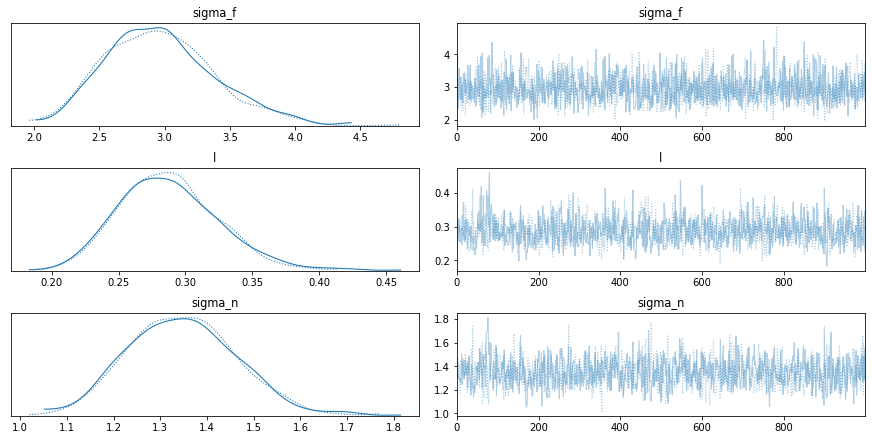

In [7]:
pm.traceplot(trace_1)

In [8]:
pm.summary(trace_1)

/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_f,2.970,0.415,2.229,3.753,0.011,0.008,1404.0,1373.0,1403.0,1358.0,1.0
l,0.288,0.037,0.218,0.353,0.001,0.001,1094.0,1086.0,1103.0,931.0,1.0
sigma_n,1.349,0.115,1.138,1.553,0.003,0.002,1178.0,1170.0,1183.0,1039.0,1.0


In [9]:
X_new = X_2D
# y = Y_2D_train
with scallop_model_1:
    scallop_pred_noisy = gp.conditional("scallop_pred_noisy",X_new,pred_noise = True)
    scallop_samples = pm.sample_posterior_predictive(trace_1, vars = [scallop_pred_noisy],samples=50)

/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sam

/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [10]:
mu_1 = np.zeros(len(X_new))
sd_1 = np.zeros(len(X_new))

for i in range(0,len(X_new)):
    mu_1[i] = np.mean(scallop_samples["scallop_pred_noisy"][:,i])
    sd_1[i] = np.std(scallop_samples["scallop_pred_noisy"][:,i])

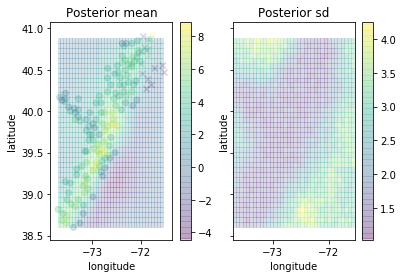

In [11]:
plot_gp_2D(gx, gy, mu_1,sd_1, X_2D_train, Y_2D_train, X_2D_test, Y_2D_test)

In [12]:
# y = Y_2D_train
with scallop_model_1:
    scallop_pred_noisy_test = gp.conditional("scallop_pred_noisy_test",X_2D_test,pred_noise = True)
    scallop_samples_test = pm.sample_posterior_predictive(trace_1, vars = [scallop_pred_noisy_test],samples=50)

mu_test_1 = np.zeros(len(X_2D_test))
sd_test_1 = np.zeros(len(X_2D_test))

for i in range(0,len(X_2D_test)):
    mu_test_1[i] = np.mean(scallop_samples_test["scallop_pred_noisy_test"][:,i])
    mu_test_1[i] = np.std(scallop_samples_test["scallop_pred_noisy_test"][:,i])

/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [13]:
pd.DataFrame({"pred":mu_test_1,
              "true":Y_2D_test,
              "lower": mu_test_1 - 1.96 * sd_test_1,
              "upper": mu_test_1 + 1.96 * sd_test_1})

,pred,true,lower,upper
0,2.725191,0.000000,2.725191,2.725191
1,2.925192,0.000000,2.925192,2.925192
2,2.813681,0.000000,2.813681,2.813681
3,2.265111,0.693147,2.265111,2.265111
4,2.513215,0.000000,2.513215,2.513215
5,2.001486,0.000000,2.001486,2.001486
6,2.504086,5.697093,2.504086,2.504086
7,2.570649,3.850148,2.570649,2.570649
8,2.380877,3.178054,2.380877,2.380877
9,2.038988,0.693147,2.038988,2.038988


In [14]:
RMSE = np.sqrt(np.mean((np.exp(mu_test_1) - np.exp(Y_2D_test))**2))
RMSE

75.27183458378045

Define the prior of those three parameters :
1. l ~ HalfCauchy(3)
2. sigma_f ~ HalfCauchy(3)
3. sigma_n ~ halfNormal(1)


Sampling by Nuts

In [16]:
import pymc3 as pm
# hyperparameter priors
number_of_dim = 2
niter =1000
x = X_2D_train
y = Y_2D_train
with pm.Model() as scallop_model_2:
    l = pm.HalfCauchy("l",3)
    sigma_f = pm.HalfCauchy("sigma_f",3)

# convariance function and marginal GP
with scallop_model_2:
    K = sigma_f ** 2 * pm.gp.cov.ExpQuad(number_of_dim, ls = l)
    gp = pm.gp.Marginal(cov_func=K)
    
# marginal likelihood
with scallop_model_2:
    sigma_n = pm.HalfNormal('sigma_n', 1)
    tot_catch = gp.marginal_likelihood("tot_catch", X = x, y = y, noise = sigma_n)
    
# model fitting
with scallop_model_2:
    trace_2 = pm.sample(niter,random_seed=123, progressbar=True, tune=500)



/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 31 seconds.
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


/Users/shenyue/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:297: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a341e4ba8>,
      dtype=object)

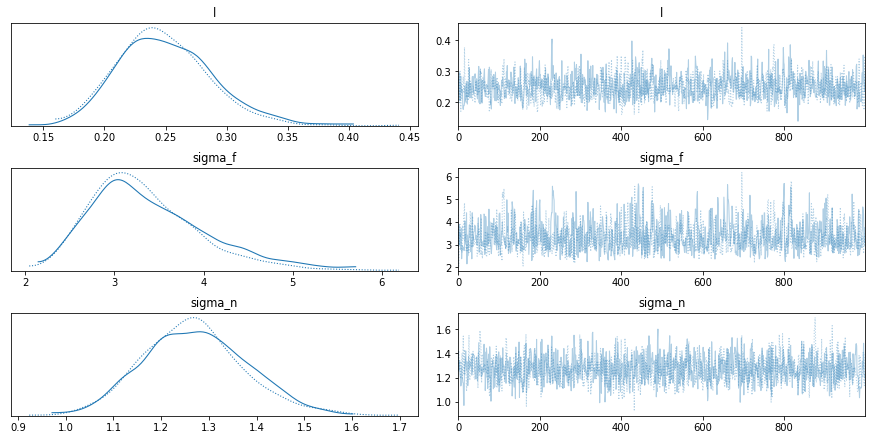

In [20]:
pm.traceplot(trace_2)

In [18]:
pm.summary(trace_2)

/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
l,0.250,0.038,0.183,0.322,0.001,0.001,1149.0,1132.0,1165.0,1213.0,1.0
sigma_f,3.372,0.635,2.350,4.584,0.020,0.015,967.0,917.0,1096.0,983.0,1.0
sigma_n,1.270,0.107,1.078,1.473,0.003,0.002,1487.0,1487.0,1488.0,1487.0,1.0


In [19]:
X_new = X_2D
# y = Y_2D_train
with scallop_model_2:
    scallop_pred_noisy_2 = gp.conditional("scallop_pred_noisy_2",X_new,pred_noise = True)
    scallop_samples_2 = pm.sample_posterior_predictive(trace_2, vars = [scallop_pred_noisy_2],samples=50)

/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [21]:
mu_2 = np.zeros(len(X_new))
sd_2 = np.zeros(len(X_new))

for i in range(0,len(X_new)):
    mu_2[i] = np.mean(scallop_samples_2["scallop_pred_noisy_2"][:,i])
    sd_2[i] = np.std(scallop_samples_2["scallop_pred_noisy_2"][:,i])

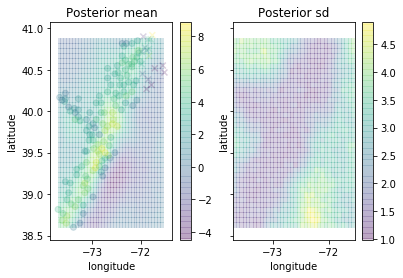

In [22]:
plot_gp_2D(gx, gy, mu_2,sd_2, X_2D_train, Y_2D_train, X_2D_test, Y_2D_test)

In [23]:
# y = Y_2D_train
with scallop_model_2:
    scallop_pred_noisy_test_2 = gp.conditional("scallop_pred_noisy_test_2",X_2D_test,pred_noise = True)
    scallop_samples_test_2 = pm.sample_posterior_predictive(trace_2, vars = [scallop_pred_noisy_test_2],samples=50)

/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [24]:
mu_test_2 = np.zeros(len(X_2D_test))
sd_test_2 = np.zeros(len(X_2D_test))

for i in range(0,len(X_2D_test)):
    mu_test_2[i] = np.mean(scallop_samples_test_2["scallop_pred_noisy_test_2"][:,i])
    sd_test_2[i] = np.std(scallop_samples_test_2["scallop_pred_noisy_test_2"][:,i])

In [25]:
pd.DataFrame({"pred":mu_test_2,
              "true":Y_2D_test,
              "lower": mu_test_2 - 1.96 * sd_test_2,
              "upper": mu_test_2 + 1.96 * sd_test_2})

,pred,true,lower,upper
0,1.182335,0.000000,-5.450318,7.814988
1,1.166396,0.000000,-4.777515,7.110308
2,0.287593,0.000000,-5.977798,6.552983
3,0.989401,0.693147,-4.004459,5.983260
4,0.489214,0.000000,-5.291112,6.269540
5,0.856101,0.000000,-4.445087,6.157289
6,1.476949,5.697093,-5.084709,8.038607
7,1.640904,3.850148,-3.881312,7.163120
8,2.073754,3.178054,-3.469784,7.617291
9,2.413151,0.693147,-2.847465,7.673767


In [26]:
RMSE = np.sqrt(np.mean((np.exp(mu_test_2) - np.exp(Y_2D_test))**2))
RMSE

77.4927036802079

### Inverse Gamma distribution and Cauchy Distribution

In [24]:
from scipy.stats import invgamma, halfcauchy

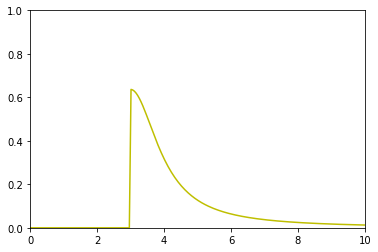

In [27]:
x = np.linspace (0, 10, 200) 
y1 = halfcauchy.pdf(x, 3)
plt.plot(x, y1, "y-", label=(r'$\alpha=5, \beta=1/5$')) 


plt.ylim([0,1])
plt.xlim([0,10])
plt.show()

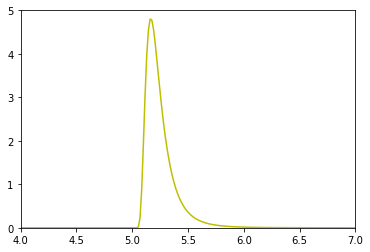

In [28]:
x = np.linspace (4, 7, 200) 
y1 = invgamma.pdf(x, a=5, loc=5)
plt.plot(x, y1, "y-", label=(r'$\alpha=5, \beta=1/5$')) 


plt.ylim([0,5])
plt.xlim([4,7])
plt.show()

In [31]:
scallop_model_1.name = "scallop_model_1"
scallop_model_2.name = "scallop_model_2"
df_comp_LOO = pm.compare({scallop_model_1: trace_1, scallop_model_2: trace_2}, ic='LOO')
df_comp_LOO

TypeError: log likelihood not found in inference data object

## MLE
Posterior
$mean = K(X_s,X)[K(X,X) + \sigma_n^2 *I]^{-1}y$\
$cov = K(X_s,X_s) - K(X_s,X)[K(X,X) + \sigma_n^2 *I]^{-1} K(X,X_s)$\
$logp(y|X, \theta) = -\frac{1}{2}y^T(K + \sigma_n^2)^{-1}y - 1/2log(K + \sigma_n^2) - \frac{n}{2}log(2\pi)$



In [5]:
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize
from numpy.linalg import inv
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def posterior_predictive(kernel, X_s, X_train, Y_train,l=1.0, sigma_f=1.0, sigma_y=1e-8):
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s_ = kernel(X_s, X_train, l, sigma_f)
    K__s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f)
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s_.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s_.dot(K_inv).dot(K__s)

    return mu_s, cov_s

def nll_fn(X_train, Y_train):
    
    def neg_log_lik(theta):
        # theta[0] = l
        # theta[1] = sigma_f
        # theta[2] = sigma_n
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + theta[2]**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.T.dot(inv(K)).dot(Y_train) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    return neg_log_lik

res = minimize(nll_fn(X_2D_train, Y_2D_train), [1, 1, 1], 
               bounds=((1e-5, None), (1e-5, None), (1e-5, None)),
               method='L-BFGS-B')


In [6]:
l_opt, sigma_f_opt, sigma_n_opt = res.x
l_opt, sigma_f_opt, sigma_n_opt

(0.23829945374047984, 3.179205992284748, 1.2565761471839443)

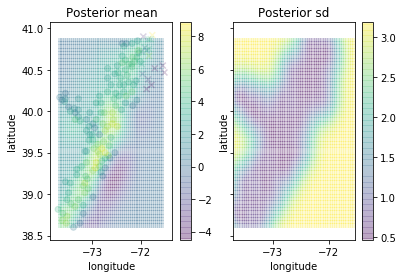

In [13]:
# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(kernel, X_2D, X_2D_train, Y_2D_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=sigma_n_opt)
plot_gp_2D(gx, gy, mu_s,np.sqrt(np.diag(cov_s)), X_2D_train, Y_2D_train, X_2D_test, Y_2D_test)

RMSE

In [14]:
mu_s_test, cov_s_test = posterior_predictive(kernel, X_2D_test, X_2D_train, Y_2D_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=sigma_n_opt)
RMSE = np.sqrt(np.mean((np.exp(mu_s_test) - np.exp(Y_2D_test))**2))
RMSE

77.64087592523173

In [15]:
mu_s_test, cov_s_test = posterior_predictive(kernel, X_2D_test, X_2D_train, Y_2D_train, l=1, sigma_f=1, sigma_y=0.2)
RMSE = np.sqrt(np.mean((np.exp(mu_s_test) - np.exp(Y_2D_test))**2))
RMSE

69.13349704041428